# SARIMA Model for Hotel Price Forecasting

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy import stats

import pickle
import joblib
from datetime import datetime, timedelta

np.random.seed(42)

# 1. Load and Prepare Data

In [3]:
# Load data
df = pd.read_csv('input_data/Multi-Year Price Data (Aggregate).csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Check for missing dates and fill if needed
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
df_complete = pd.DataFrame({'Date': date_range})
df_complete = df_complete.merge(df, on='Date', how='left')

# Interpolate missing values
df_complete['Price'] = df_complete['Price'].interpolate(method='linear')
df = df_complete.copy()
df.set_index('Date', inplace=True)

print(f"Dataset: {df.index.min().date()} to {df.index.max().date()}")
print(f"Total observations: {len(df)}")
print(f"Missing values: {df['Price'].isna().sum()}")
print(f"\nPrice range: ${df['Price'].min():.2f} - ${df['Price'].max():.2f}")
print(f"Mean price: ${df['Price'].mean():.2f}")
print(f"Std deviation: ${df['Price'].std():.2f}")

Dataset: 2012-01-01 to 2016-01-16
Total observations: 1477
Missing values: 0

Price range: $81.00 - $281.00
Mean price: $114.09
Std deviation: $20.48


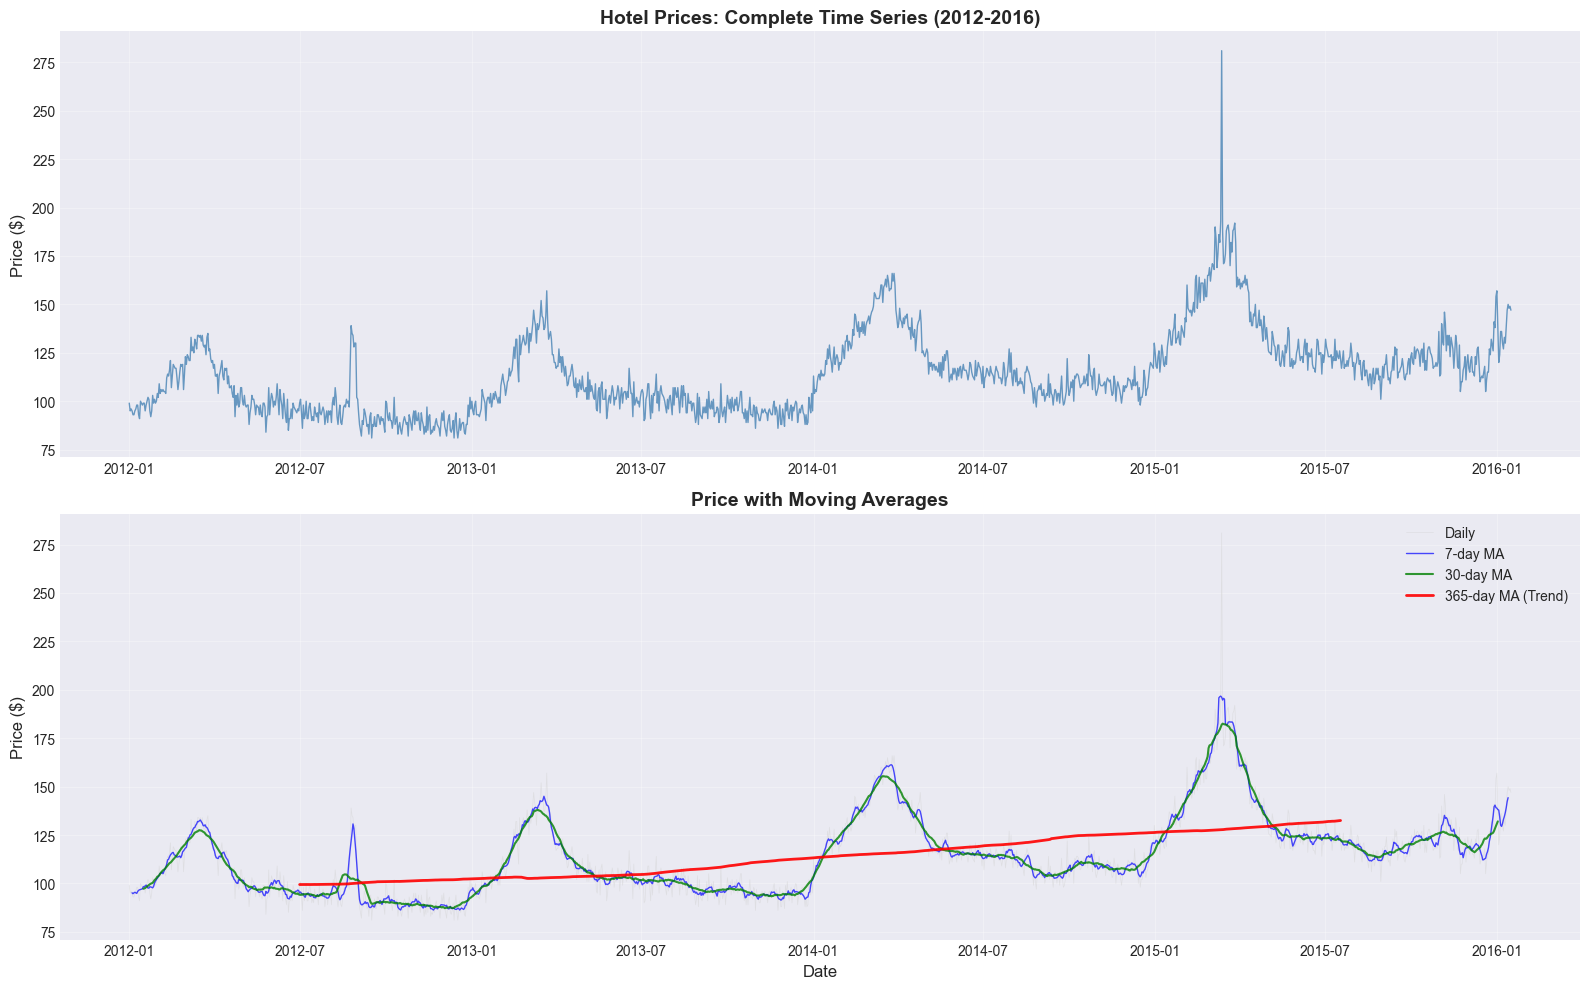

In [4]:
# Visualize the full time series
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full series
axes[0].plot(df.index, df['Price'], linewidth=1, color='steelblue', alpha=0.8)
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].set_title('Hotel Prices: Complete Time Series (2012-2016)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Rolling statistics
df['MA_7'] = df['Price'].rolling(window=7, center=True).mean()
df['MA_30'] = df['Price'].rolling(window=30, center=True).mean()
df['MA_365'] = df['Price'].rolling(window=365, center=True).mean()

axes[1].plot(df.index, df['Price'], linewidth=0.5, color='lightgray', alpha=0.5, label='Daily')
axes[1].plot(df.index, df['MA_7'], linewidth=1, color='blue', alpha=0.7, label='7-day MA')
axes[1].plot(df.index, df['MA_30'], linewidth=1.5, color='green', alpha=0.8, label='30-day MA')
axes[1].plot(df.index, df['MA_365'], linewidth=2, color='red', alpha=0.9, label='365-day MA (Trend)')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Price ($)', fontsize=12)
axes[1].set_title('Price with Moving Averages', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Drop MA columns
df = df[['Price']]

## 2. Train-Validation Split

In [5]:
# Split data
split_date = '2015-07-01'
train_data = df[df.index < split_date].copy()
validation_data = df[df.index >= split_date].copy()

print(f"Training: {train_data.index.min().date()} to {train_data.index.max().date()} ({len(train_data)} days)")
print(f"Validation: {validation_data.index.min().date()} to {validation_data.index.max().date()} ({len(validation_data)} days)")
print(f"Split ratio: {len(train_data)/len(df)*100:.1f}% train / {len(validation_data)/len(df)*100:.1f}% validation")

Training: 2012-01-01 to 2015-06-30 (1277 days)
Validation: 2015-07-01 to 2016-01-16 (200 days)
Split ratio: 86.5% train / 13.5% validation


## 3. Stationarity Analysis

In [6]:
def comprehensive_stationarity_test(series, name='Series'):
    """
    Perform multiple stationarity tests
    """
    print(f"\n{'='*70}")
    print(f"STATIONARITY TESTS: {name}")
    print(f"{'='*70}")
    
    # ADF Test
    adf_result = adfuller(series.dropna(), autolag='AIC')
    print(f"\n1. Augmented Dickey-Fuller Test:")
    print(f"   ADF Statistic: {adf_result[0]:.6f}")
    print(f"   p-value: {adf_result[1]:.6f}")
    print(f"   Critical Values: {adf_result[4]}")
    print(f"   → {'STATIONARY' if adf_result[1] < 0.05 else 'NON-STATIONARY'} (α=0.05)")
    
    # KPSS Test
    kpss_result = kpss(series.dropna(), regression='ct', nlags='auto')
    print(f"\n2. KPSS Test (null: series is stationary):")
    print(f"   KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"   p-value: {kpss_result[1]:.6f}")
    print(f"   Critical Values: {kpss_result[3]}")
    print(f"   → {'STATIONARY' if kpss_result[1] > 0.05 else 'NON-STATIONARY'} (α=0.05)")
    
    print(f"\n{'='*70}\n")
    
    return adf_result[1] < 0.05, kpss_result[1] > 0.05

# Test original series
adf_stat, kpss_stat = comprehensive_stationarity_test(train_data['Price'], 'Original Series')


STATIONARITY TESTS: Original Series

1. Augmented Dickey-Fuller Test:
   ADF Statistic: -2.503270
   p-value: 0.114681
   Critical Values: {'1%': np.float64(-3.4355464009607255), '5%': np.float64(-2.8638347524449888), '10%': np.float64(-2.5679917506718044)}
   → NON-STATIONARY (α=0.05)

2. KPSS Test (null: series is stationary):
   KPSS Statistic: 0.192377
   p-value: 0.018858
   Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
   → NON-STATIONARY (α=0.05)




In [7]:
# Test differenced series
train_diff1 = train_data['Price'].diff().dropna()
adf_stat_d1, kpss_stat_d1 = comprehensive_stationarity_test(train_diff1, 'First Difference (d=1)')


STATIONARITY TESTS: First Difference (d=1)

1. Augmented Dickey-Fuller Test:
   ADF Statistic: -9.013771
   p-value: 0.000000
   Critical Values: {'1%': np.float64(-3.4355464009607255), '5%': np.float64(-2.8638347524449888), '10%': np.float64(-2.5679917506718044)}
   → STATIONARY (α=0.05)

2. KPSS Test (null: series is stationary):
   KPSS Statistic: 0.030414
   p-value: 0.100000
   Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
   → STATIONARY (α=0.05)




In [ ]:
# Test seasonal difference
train_diff7 = train_data['Price'].diff(7).dropna()
adf_stat_s7, kpss_stat_s7 = comprehensive_stationarity_test(train_diff7, 'Seasonal Difference (s=7)')


STATIONARITY TESTS: Seasonal Difference (s=7)

1. Augmented Dickey-Fuller Test:
   ADF Statistic: -5.362098
   p-value: 0.000004
   Critical Values: {'1%': np.float64(-3.4356090875394525), '5%': np.float64(-2.863862410805964), '10%': np.float64(-2.568006480268158)}
   → STATIONARY (α=0.05)

2. KPSS Test (null: series is stationary):
   KPSS Statistic: 0.042962
   p-value: 0.100000
   Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
   → STATIONARY (α=0.05)




In [9]:
# Test combined: first difference + seasonal difference
train_diff_both = train_data['Price'].diff(7).diff().dropna()
adf_stat_both, kpss_stat_both = comprehensive_stationarity_test(
    train_diff_both, 
    'Combined Difference (d=1, D=1, s=7)'
)


STATIONARITY TESTS: Combined Difference (d=1, D=1, s=7)

1. Augmented Dickey-Fuller Test:
   ADF Statistic: -12.777042
   p-value: 0.000000
   Critical Values: {'1%': np.float64(-3.4356090875394525), '5%': np.float64(-2.863862410805964), '10%': np.float64(-2.568006480268158)}
   → STATIONARY (α=0.05)

2. KPSS Test (null: series is stationary):
   KPSS Statistic: 0.017112
   p-value: 0.100000
   Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
   → STATIONARY (α=0.05)




## 4. ACF and PACF Analysis for Parameter Selection

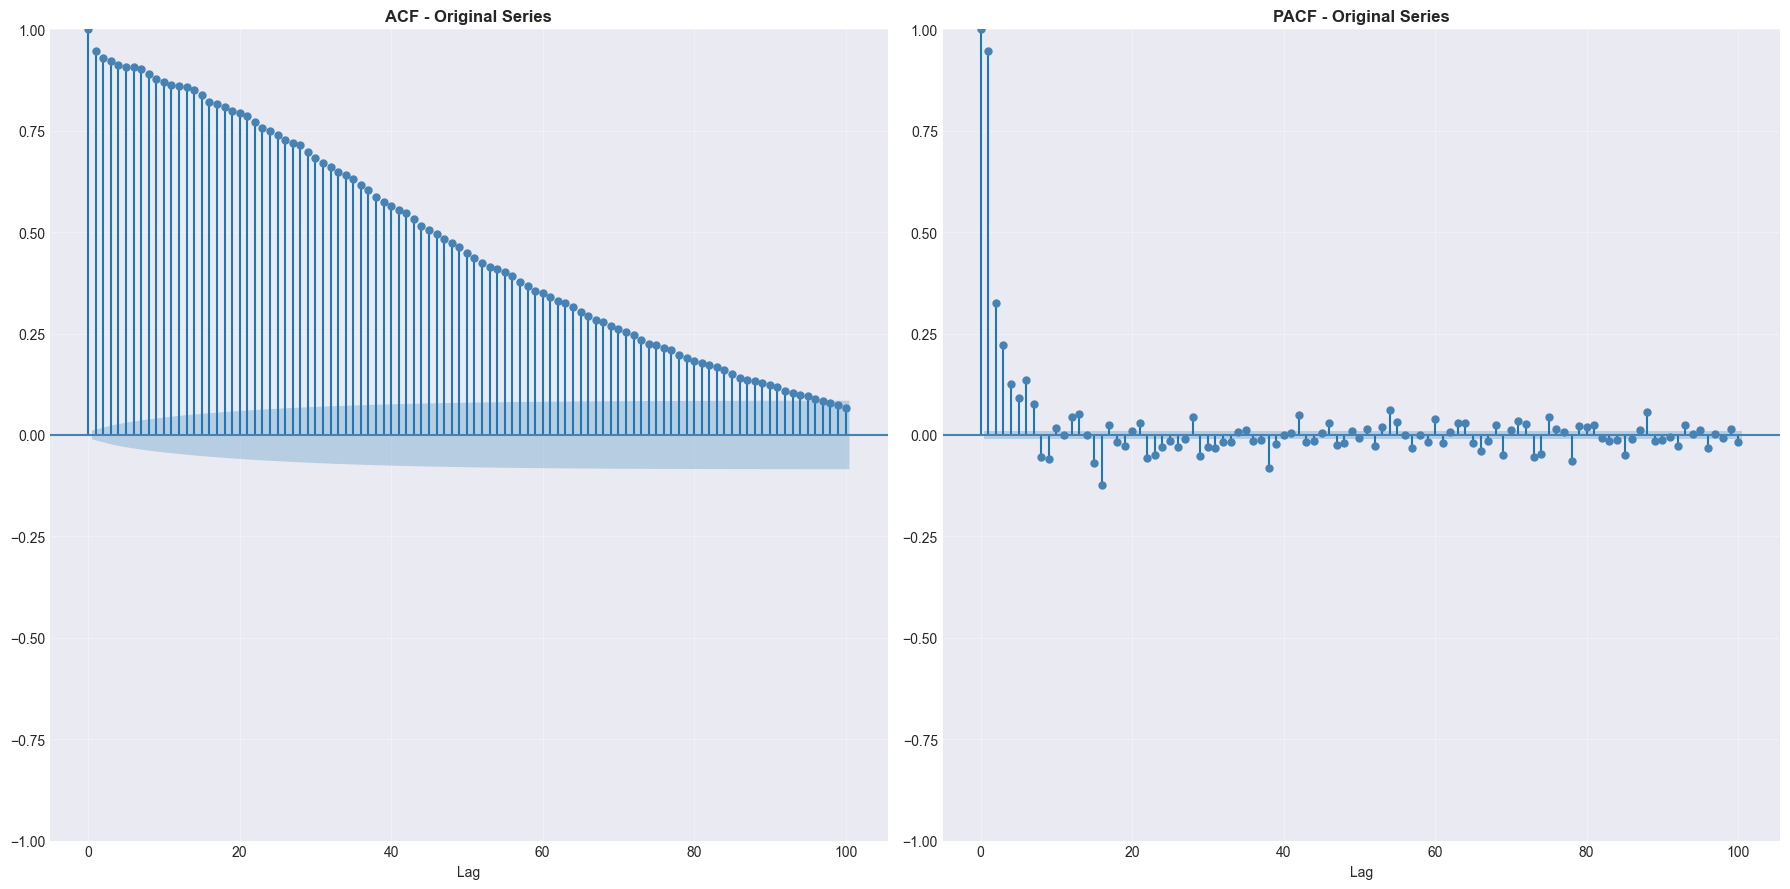

In [10]:
# Comprehensive ACF/PACF plots
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Original series
plot_acf(train_data['Price'], lags=100, ax=axes[0], color='steelblue', alpha=0.7)
axes[0].set_title('ACF - Original Series', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=10)
axes[0].grid(True, alpha=0.3)

plot_pacf(train_data['Price'], lags=100, ax=axes[1], color='steelblue', alpha=0.7)
axes[1].set_title('PACF - Original Series', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


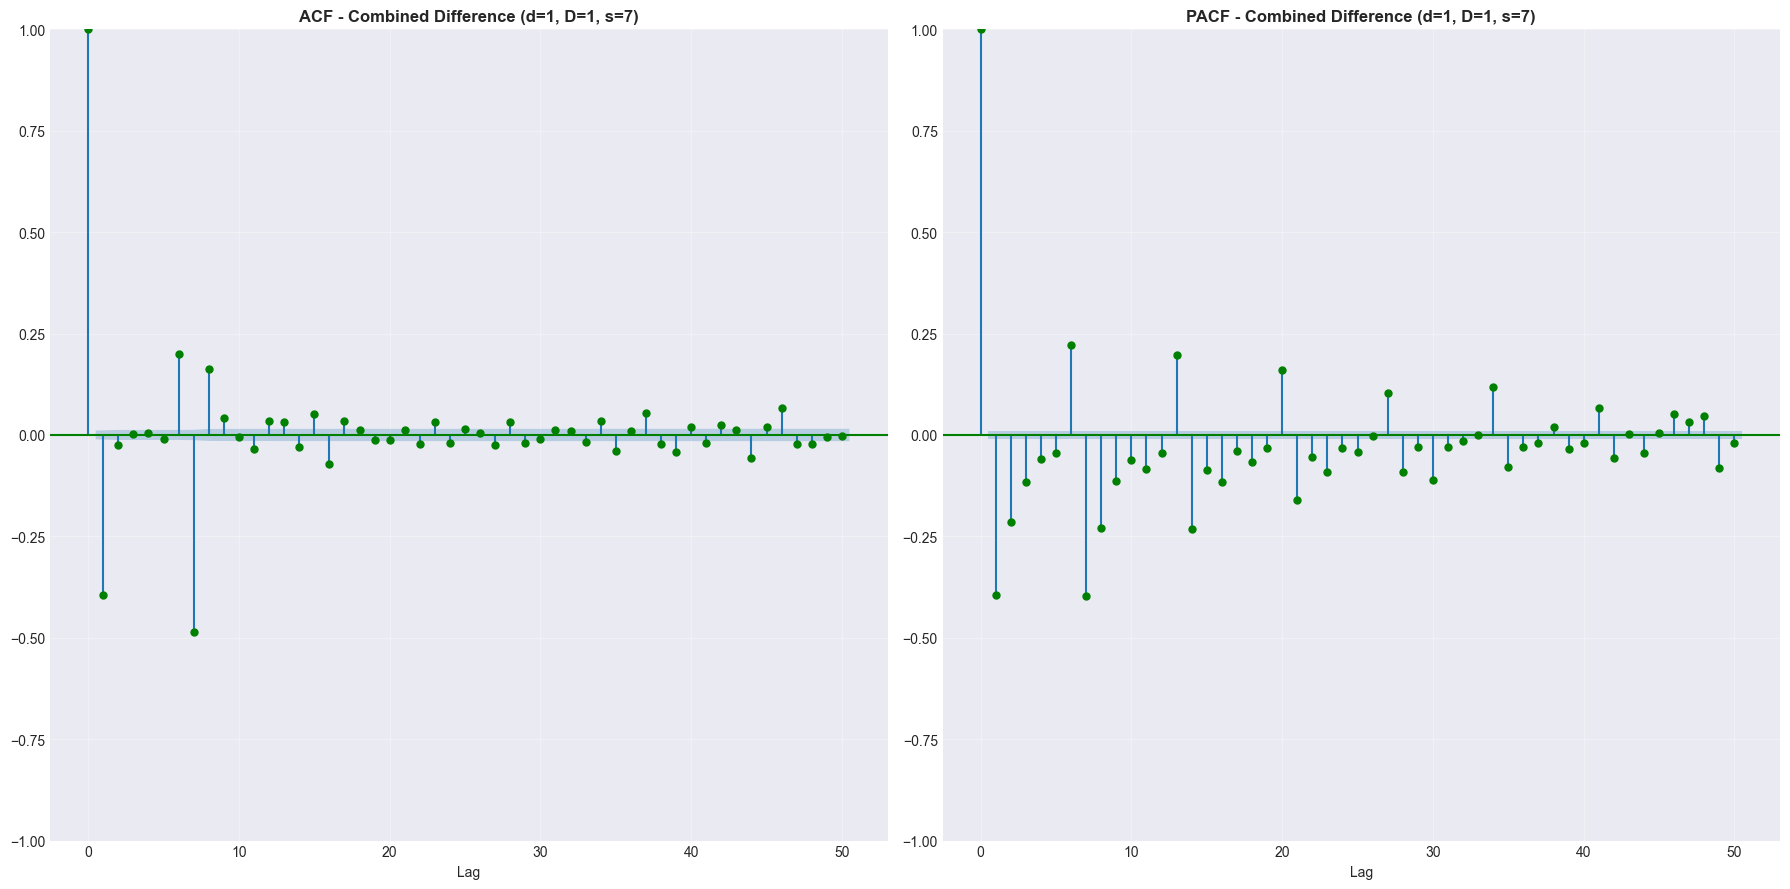

In [11]:
# ACF/PACF for combined differenced series (d=1, D=1, s=7)
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

plot_acf(train_diff_both, lags=50, ax=axes[0], color='green', alpha=0.7)
axes[0].set_title('ACF - Combined Difference (d=1, D=1, s=7)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=10)
axes[0].grid(True, alpha=0.3)

plot_pacf(train_diff_both, lags=50, ax=axes[1], color='green', alpha=0.7)
axes[1].set_title('PACF - Combined Difference (d=1, D=1, s=7)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# for q: ACF plot, we see 2 lags are there outside the confidence zone, so q=2
# for Q: ACF plot, we see lag 7 and lag 14 are outside the confidence zone and lag 21 is inside, so Q=2

# for p: PACF plot, we see significant cut-off after lag 2,so p=2
# for P: PACF plot, we see significantly less correlation after lag 21, so P=2

# Version 1
# p,d,q = 2, 1, 2
# P,D,Q,s = 2, 1, 2, 7

# Version 2
# p,d,q = 2, 1, 3
# P,D,Q,s = 1, 1, 1, 7

# Version 3
# p,d,q = 1, 1, 2
# P,D,Q,s = 1, 1, 1, 7

## 5. Parameter Selection Based on Analysis

For q: ACF plot, we see 2 lags are there outside the confidence zone, so q=2 \
For Q: ACF plot, we see lag 7 and lag 14 are outside the confidence zone and lag 21 is inside, so Q=2

For p: PACF plot, we see significant cut-off after lag 2,so p=2 \
For P: PACF plot, we see significantly less correlation after lag 21, so P=2

Version 1\
p,d,q = 2, 1, 2 \
P,D,Q,s = 2, 1, 2, 7

Version 2 \
p,d,q = 2, 1, 3 \
P,D,Q,s = 1, 1, 1, 7

Version 3 \
p,d,q = 1, 1, 2 \
P,D,Q,s = 1, 1, 1, 7

In [13]:
# Define three candidate models
candidate_models = [
    {
        'name': 'Model 1',
        'order': (2, 1, 2), #p,d,q
        'seasonal_order': (2, 1, 2, 7), #P,Q,D,s
        'description': 'version 1'
    },
    {
        'name': 'Model 2',
        'order': (2, 1, 3), #p,d,q
        'seasonal_order': (1, 1, 1, 7), #P,Q,D,s
        'description': 'version 2'
    },
    {
        'name': 'Model 3',
        'order': (1, 1, 2), # p,q,d
        'seasonal_order': (1, 1, 1, 7), #P,Q,D,s
        'description': 'version 3'
    }
]

print("\n" + "="*70)
print("CANDIDATE MODELS FOR EVALUATION")
print("="*70)
for i, model in enumerate(candidate_models, 1):
    print(f"\n{model['name']}")
    print(f"  Order (p,d,q): {model['order']}")
    print(f"  Seasonal (P,D,Q,s): {model['seasonal_order']}")
    print(f"  Description: {model['description']}")
print("\n" + "="*70)


CANDIDATE MODELS FOR EVALUATION

Model 1
  Order (p,d,q): (2, 1, 2)
  Seasonal (P,D,Q,s): (2, 1, 2, 7)
  Description: version 1

Model 2
  Order (p,d,q): (2, 1, 3)
  Seasonal (P,D,Q,s): (1, 1, 1, 7)
  Description: version 2

Model 3
  Order (p,d,q): (1, 1, 2)
  Seasonal (P,D,Q,s): (1, 1, 1, 7)
  Description: version 3



## 6. Train and Evaluate All Three Models

In [14]:
def train_and_evaluate_model(train_series, validation_series, order, seasonal_order, model_name):
    """
    Train SARIMA model and evaluate performance
    """
    print(f"\n{'='*70}")
    print(f"Training: {model_name}")
    print(f"{'='*70}")
    
    try:
        # Fit model
        model = SARIMAX(train_series, 
                       order=order, 
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        
        fitted_model = model.fit(disp=False, maxiter=500, method='lbfgs')
        
        # Make predictions
        predictions = fitted_model.forecast(steps=len(validation_series))
        
        # Calculate metrics
        mae = mean_absolute_error(validation_series, predictions)
        rmse = np.sqrt(mean_squared_error(validation_series, predictions))
        mape = mean_absolute_percentage_error(validation_series, predictions) * 100
        
        # Residual analysis
        residuals = fitted_model.resid
        ljung_box = fitted_model.test_serial_correlation('ljungbox')[0, -1, -1]
        
        print(f"✓ Model trained successfully")
        print(f"\nValidation Metrics:")
        print(f"  MAE:  ${mae:.2f}")
        print(f"  RMSE: ${rmse:.2f}")
        print(f"  MAPE: {mape:.2f}%")
        print(f"\nModel Information:")
        print(f"  AIC:  {fitted_model.aic:.2f}")
        print(f"  BIC:  {fitted_model.bic:.2f}")
        print(f"  Ljung-Box p-value: {ljung_box:.4f}")
        print(f"  Residual mean: {residuals.mean():.4f}")
        print(f"  Residual std: {residuals.std():.4f}")
        
        return {
            'fitted_model': fitted_model,
            'predictions': predictions,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'aic': fitted_model.aic,
            'bic': fitted_model.bic,
            'ljung_box_pval': ljung_box
        }
    
    except Exception as e:
        print(f"✗ Model failed: {str(e)}")
        return None

# Train all models
results = []
for model_config in candidate_models:
    result = train_and_evaluate_model(
        train_data['Price'],
        validation_data['Price'],
        model_config['order'],
        model_config['seasonal_order'],
        model_config['name']
    )
    if result:
        results.append({**model_config, **result})


Training: Model 1
✓ Model trained successfully

Validation Metrics:
  MAE:  $7.17
  RMSE: $10.14
  MAPE: 5.66%

Model Information:
  AIC:  8178.85
  BIC:  8225.05
  Ljung-Box p-value: 0.0801
  Residual mean: -0.0332
  Residual std: 7.2756

Training: Model 2
✓ Model trained successfully

Validation Metrics:
  MAE:  $7.09
  RMSE: $9.92
  MAPE: 5.62%

Model Information:
  AIC:  8215.37
  BIC:  8256.47
  Ljung-Box p-value: 0.0905
  Residual mean: -0.0498
  Residual std: 7.0906

Training: Model 3
✓ Model trained successfully

Validation Metrics:
  MAE:  $7.09
  RMSE: $9.91
  MAPE: 5.62%

Model Information:
  AIC:  8217.88
  BIC:  8248.70
  Ljung-Box p-value: 0.0858
  Residual mean: -0.0471
  Residual std: 7.0939


In [15]:
# Compare models
comparison_df = pd.DataFrame([{
    'Model': r['name'],
    'Order': r['order'],
    'Seasonal': r['seasonal_order'],
    'MAE': r['mae'],
    'RMSE': r['rmse'],
    'MAPE': r['mape'],
    'AIC': r['aic'],
    'BIC': r['bic']
} for r in results])

print("\n" + "="*100)
print("MODEL COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))
print("\n" + "="*100)

# Select best model
best_idx = comparison_df['MAE'].idxmin()
best_model_result = results[best_idx]

print(f"\n🏆 BEST MODEL: {best_model_result['name']}")
print(f"   Validation MAE: ${best_model_result['mae']:.2f}")
print(f"   Validation MAPE: {best_model_result['mape']:.2f}%")


MODEL COMPARISON
  Model     Order     Seasonal      MAE      RMSE     MAPE         AIC         BIC
Model 1 (2, 1, 2) (2, 1, 2, 7) 7.174810 10.140048 5.658289 8178.854591 8225.047069
Model 2 (2, 1, 3) (1, 1, 1, 7) 7.094559  9.917344 5.615893 8215.373556 8256.471783
Model 3 (1, 1, 2) (1, 1, 1, 7) 7.093848  9.914466 5.615710 8217.875511 8248.703949


🏆 BEST MODEL: Model 3
   Validation MAE: $7.09
   Validation MAPE: 5.62%


## 7. Visualize Validation Performance

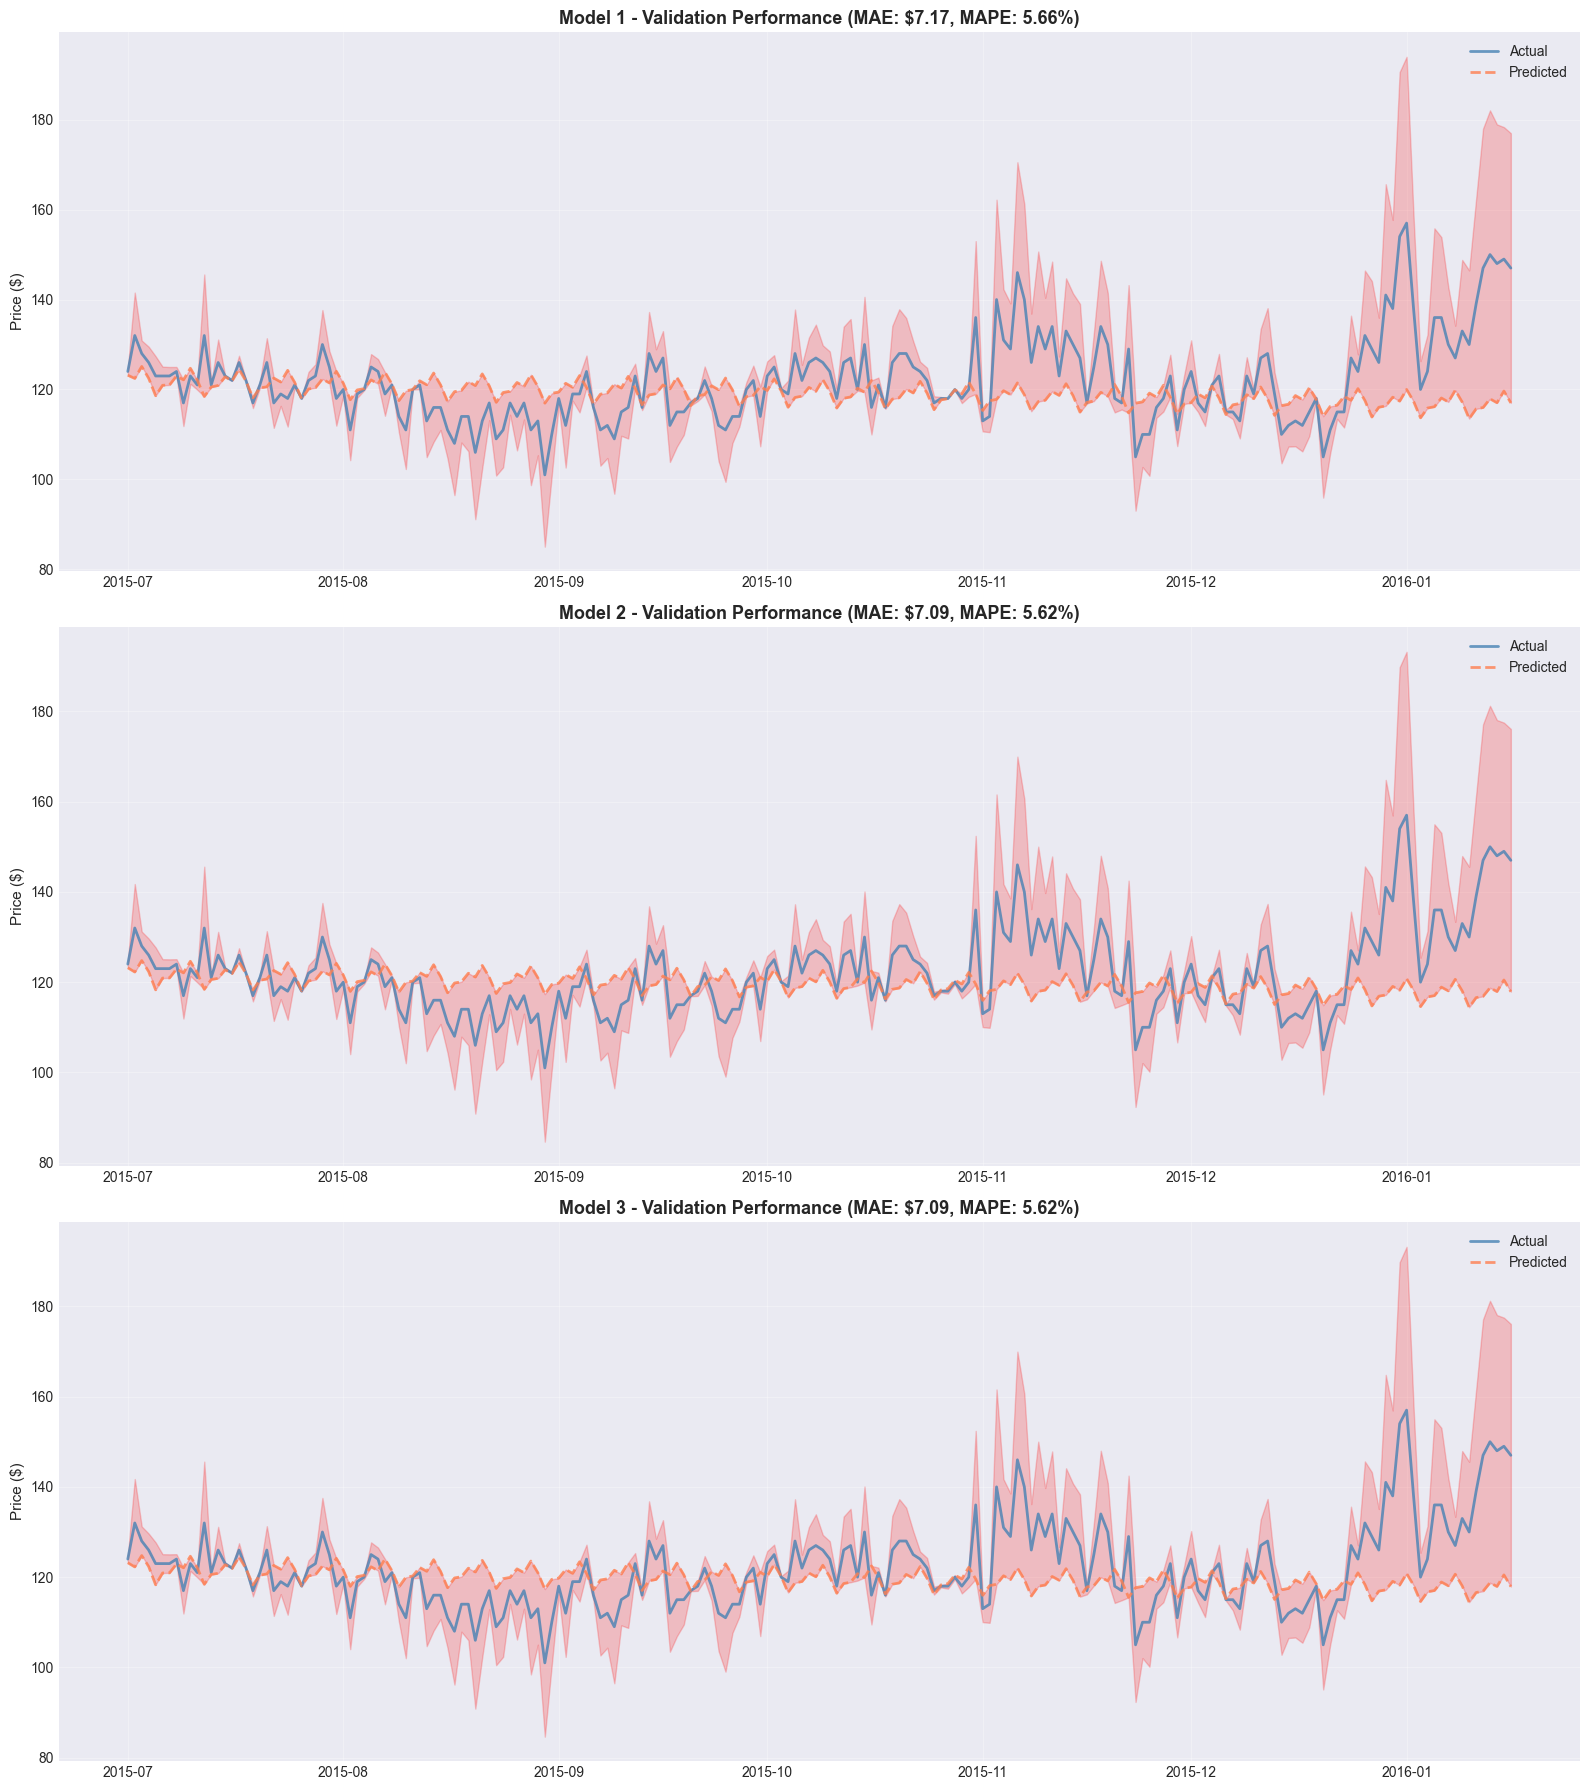

In [16]:
# Plot all model predictions
fig, axes = plt.subplots(len(results), 1, figsize=(16, 6*len(results)))
if len(results) == 1:
    axes = [axes]

for idx, result in enumerate(results):
    ax = axes[idx]
    
    # Plot actual and predicted
    ax.plot(validation_data.index, validation_data['Price'], 
            label='Actual', linewidth=2, color='steelblue', alpha=0.8)
    ax.plot(validation_data.index, result['predictions'], 
            label='Predicted', linewidth=2, color='coral', alpha=0.8, linestyle='--')
    
    # Error band
    errors = np.abs(validation_data['Price'].values - result['predictions'].values)
    ax.fill_between(validation_data.index, 
                     validation_data['Price'] - errors,
                     validation_data['Price'] + errors,
                     alpha=0.2, color='red')
    
    ax.set_ylabel('Price ($)', fontsize=11)
    ax.set_title(f"{result['name']} - Validation Performance (MAE: ${result['mae']:.2f}, MAPE: {result['mape']:.2f}%)", 
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Create Ensemble Forecast (All 3 Models)

### Strategy for Long-Term Forecast:
For forecasting 4 years ahead (2016 → 2020), we'll use an ensemble approach:
1. Retrain all 3 models on full dataset
2. Generate forecasts from each model
3. Combine using weighted average (weights based on validation performance)
4. This provides more robust predictions than a single model

In [17]:
# Retrain all models on full dataset
print("Training ensemble of all 3 models on full dataset...\n")

ensemble_models = []
for result in results:
    model = SARIMAX(df['Price'],
                   order=result['order'],
                   seasonal_order=result['seasonal_order'],
                   enforce_stationarity=False,
                   enforce_invertibility=False)
    
    fitted = model.fit(disp=False, maxiter=500, method='lbfgs')
    ensemble_models.append({
        'name': result['name'],
        'model': fitted,
        'mae': result['mae'],
        'weight': 1 / result['mae']  # Inverse MAE weighting
    })
    print(f"✓ Trained: {result['name']}")

# Normalize weights
total_weight = sum(m['weight'] for m in ensemble_models)
for m in ensemble_models:
    m['weight'] = m['weight'] / total_weight
    print(f"  {m['name']}: weight = {m['weight']:.3f}")

Training ensemble of all 3 models on full dataset...

✓ Trained: Model 1
✓ Trained: Model 2
✓ Trained: Model 3
  Model 1: weight = 0.331
  Model 2: weight = 0.335
  Model 3: weight = 0.335


## 10. February 2020 Forecast with Ensemble

In [18]:
# Calculate forecast parameters
last_date = df.index.max()
forecast_start = pd.Timestamp('2020-02-01')
forecast_end = pd.Timestamp('2020-02-29')

days_to_feb = (forecast_start - last_date).days
days_in_feb = (forecast_end - forecast_start).days + 1
total_steps = days_to_feb + days_in_feb

print(f"Last observation: {last_date.date()}")
print(f"Forecast target: February 2020")
print(f"Days to forecast: {days_to_feb}")
print(f"Days in February 2020: {days_in_feb}")
print(f"Total forecast steps: {total_steps}")
print(f"\nWarning: Forecasting {days_to_feb} days ahead is challenging for SARIMA!")
print(f"Ensemble approach will help reduce uncertainty.\n")

Last observation: 2016-01-16
Forecast target: February 2020
Days to forecast: 1477
Days in February 2020: 29
Total forecast steps: 1506

Ensemble approach will help reduce uncertainty.



In [19]:
# Generate ensemble forecast
print("Generating ensemble forecast...\n")

all_forecasts = []
all_confidence_intervals = []

for m in ensemble_models:
    forecast_result = m['model'].get_forecast(steps=total_steps)
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int(alpha=0.05)
    
    all_forecasts.append(forecast_mean.values)
    all_confidence_intervals.append(forecast_ci)
    
    print(f"✓ {m['name']}: Forecast complete")

# Weighted ensemble
weights = np.array([m['weight'] for m in ensemble_models])
ensemble_forecast = np.average(all_forecasts, axis=0, weights=weights)

# Create date range
forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=total_steps, freq='D')

# Extract February 2020
feb_mask = (forecast_dates >= forecast_start) & (forecast_dates <= forecast_end)
feb_dates = forecast_dates[feb_mask]
feb_forecast = ensemble_forecast[feb_mask]

# Calculate ensemble confidence intervals (average of all CIs)
avg_lower = np.mean([ci.iloc[:, 0].values for ci in all_confidence_intervals], axis=0)
avg_upper = np.mean([ci.iloc[:, 1].values for ci in all_confidence_intervals], axis=0)

feb_lower = avg_lower[feb_mask]
feb_upper = avg_upper[feb_mask]

print(f"\n✓ Ensemble forecast complete!")

Generating ensemble forecast...

✓ Model 1: Forecast complete
✓ Model 2: Forecast complete
✓ Model 3: Forecast complete

✓ Ensemble forecast complete!


In [20]:
# Create results DataFrame
feb_2020_predictions = pd.DataFrame({
    'Date': feb_dates,
    'Predicted_Price': feb_forecast,
    'Lower_CI_95': feb_lower,
    'Upper_CI_95': feb_upper,
    'CI_Width': feb_upper - feb_lower
}).set_index('Date')

# Add individual model predictions for transparency
for i, m in enumerate(ensemble_models):
    model_feb_forecast = all_forecasts[i][feb_mask]
    feb_2020_predictions[f'{m["name"][:8]}_Pred'] = model_feb_forecast

print("\n" + "="*100)
print("FEBRUARY 2020 ENSEMBLE FORECAST")
print("="*100)
print(feb_2020_predictions.to_string())
print("\n" + "="*100)


FEBRUARY 2020 ENSEMBLE FORECAST
            Predicted_Price  Lower_CI_95  Upper_CI_95     CI_Width  Model 1_Pred  Model 2_Pred  Model 3_Pred
Date                                                                                                        
2020-02-01       283.776794  -611.342552  1179.057288  1790.399840    305.283703    274.157830    272.130571
2020-02-02       278.658938  -617.253813  1174.732477  1791.986290    300.117566    269.058162    267.042266
2020-02-03       280.445991  -616.251891  1177.304707  1793.556598    301.910916    270.842283    268.826024
2020-02-04       283.110371  -614.370275  1180.752405  1795.122680    304.649265    273.478264    271.445666
2020-02-05       283.864364  -614.398373  1182.288523  1796.686895    305.407797    274.229112    272.198316
2020-02-06       283.478886  -615.565288  1182.684595  1798.249884    305.037355    273.836638    271.804967
2020-02-07       285.094764  -614.730261  1185.081353  1799.811614    306.657117    275.449473 

In [21]:
# Summary statistics
print("\nFEBRUARY 2020 FORECAST SUMMARY:")
print("="*60)
print(f"Mean Predicted Price:    ${feb_2020_predictions['Predicted_Price'].mean():.2f}")
print(f"Median Predicted Price:  ${feb_2020_predictions['Predicted_Price'].median():.2f}")
print(f"Min Predicted Price:     ${feb_2020_predictions['Predicted_Price'].min():.2f}")
print(f"Max Predicted Price:     ${feb_2020_predictions['Predicted_Price'].max():.2f}")
print(f"Std Dev:                 ${feb_2020_predictions['Predicted_Price'].std():.2f}")
print(f"\nAverage CI Width:        ${feb_2020_predictions['CI_Width'].mean():.2f}")
print(f"Price Range (95% CI):    ${feb_2020_predictions['Lower_CI_95'].min():.2f} - ${feb_2020_predictions['Upper_CI_95'].max():.2f}")
print("="*60)

# Compare with historical patterns
historical_feb_2016 = df[(df.index >= '2016-02-01') & (df.index <= '2016-02-29')]
if len(historical_feb_2016) > 0:
    print(f"\nComparison with February 2016 (most recent):")
    print(f"  Feb 2016 Mean: ${historical_feb_2016['Price'].mean():.2f}")
    print(f"  Feb 2020 Forecast: ${feb_2020_predictions['Predicted_Price'].mean():.2f}")
    print(f"  Projected Growth: {((feb_2020_predictions['Predicted_Price'].mean() / historical_feb_2016['Price'].mean()) - 1) * 100:.1f}%")


FEBRUARY 2020 FORECAST SUMMARY:
Mean Predicted Price:    $283.69
Median Predicted Price:  $284.39
Min Predicted Price:     $278.66
Max Predicted Price:     $287.02
Std Dev:                 $2.26

Average CI Width:        $1812.40
Price Range (95% CI):    $-631.82 - $1203.64


## 12. Save Models and Results

In [22]:
# Save ensemble models

min_mae=min([i['mae'] for i in ensemble_models])
best_model=[i['model'] for i in ensemble_models if i['mae']==min_mae] 

ensemble_save = {
    'models': [{
        'name': m['name'],
        'model': m['model'],
        'weight': m['weight'],
        'mae': m['mae']
    } for m in ensemble_models],
    'best_model': best_model[0],
    'metadata': {
        'training_period': f"{df.index.min().date()} to {df.index.max().date()}",
        'validation_mae': best_model_result['mae'],
        'validation_mape': best_model_result['mape'],
        'best_order': best_model_result['order'],
        'best_seasonal_order': best_model_result['seasonal_order'],
        'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
}

# Save with joblib (better for sklearn/statsmodels objects)
joblib.dump(ensemble_save, 'models/saved_models/sarima_ensemble_models.joblib')
print("✓ Ensemble models saved: sarima_ensemble_models.joblib")

# Save best individual model
joblib.dump(best_model[0], 'models/saved_models/sarima_best_model.joblib')
print("✓ Best model saved: sarima_best_model.joblib")

# Save predictions
feb_2020_predictions.to_csv('predictions/february_2020_ensemble_predictions.csv')
print("✓ Predictions saved: february_2020_ensemble_predictions.csv")

# # Save model comparison
# comparison_df.to_csv('/mnt/user-data/outputs/model_comparison.csv', index=False)
# print("✓ Model comparison saved: model_comparison.csv")

print("\n" + "="*70)
print("ALL MODELS AND RESULTS SAVED SUCCESSFULLY")
print("="*70)

✓ Ensemble models saved: sarima_ensemble_models.joblib
✓ Best model saved: sarima_best_model.joblib
✓ Predictions saved: february_2020_ensemble_predictions.csv

ALL MODELS AND RESULTS SAVED SUCCESSFULLY


In [23]:
# Example: Load ensemble and make new predictions
'''
import joblib

# Load ensemble
ensemble = joblib.load('sarima_ensemble_models.joblib')

# Make predictions with best model
best_model = ensemble['best_model']
forecast = best_model.forecast(steps=30)

# Make predictions with ensemble
ensemble_forecasts = []
for model_info in ensemble['models']:
    pred = model_info['model'].forecast(steps=30)
    ensemble_forecasts.append(pred.values * model_info['weight'])

final_forecast = np.sum(ensemble_forecasts, axis=0)
'''
print("See code above for loading and using saved models")

See code above for loading and using saved models
